In [1]:

!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 212 kB 51.2 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
tweets, labels = get_tweets(train)

In [8]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something',
 'sadness')

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[10]]))

[[2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]]


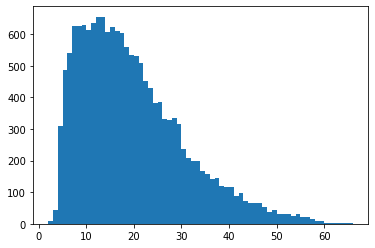

In [10]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [13]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [14]:
padded_train_sequences[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [15]:
classes = set(labels)
print(classes)

{'sadness', 'anger', 'joy', 'surprise', 'love', 'fear'}


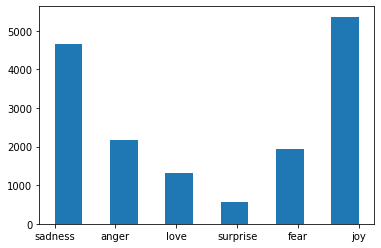

In [16]:
plt.hist(labels, bins=11)
plt.show()


In [17]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())
classes_to_index

{'anger': 1, 'fear': 5, 'joy': 2, 'love': 4, 'sadness': 0, 'surprise': 3}

In [18]:
index_to_classes

{0: 'sadness', 1: 'anger', 2: 'joy', 3: 'surprise', 4: 'love', 5: 'fear'}

In [19]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [20]:
train_labels = names_to_ids(labels)
print(train_labels[10])

0


In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [22]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [23]:
val_tweets[20], val_labels[20]

('i just know to begin with i am going to feel shy about it', 5)

In [24]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
500/500 [==============================] - 34s 55ms/step - loss: 1.4106 - accuracy: 0.3890 - val_loss: 1.1406 - val_accuracy: 0.5105
Epoch 2/15
500/500 [==============================] - 23s 46ms/step - loss: 0.6821 - accuracy: 0.7513 - val_loss: 0.6976 - val_accuracy: 0.7720
Epoch 3/15
500/500 [==============================] - 23s 46ms/step - loss: 0.3328 - accuracy: 0.8955 - val_loss: 0.4817 - val_accuracy: 0.8525
Epoch 4/15
500/500 [==============================] - 25s 50ms/step - loss: 0.2313 - accuracy: 0.9292 - val_loss: 0.4052 - val_accuracy: 0.8770
Epoch 5/15
500/500 [==============================] - 23s 47ms/step - loss: 0.1834 - accuracy: 0.9420 - val_loss: 0.3898 - val_accuracy: 0.8855
Epoch 6/15
500/500 [==============================] - 23s 46ms/step - loss: 0.1583 - accuracy: 0.9516 - val_loss: 0.4614 - val_accuracy: 0.8610
Epoch 7/15
500/500 [==============================] - 23s 46ms/step - loss: 0.1263 - accuracy: 0.9599 - val_loss: 0.3665 - val_accuracy:

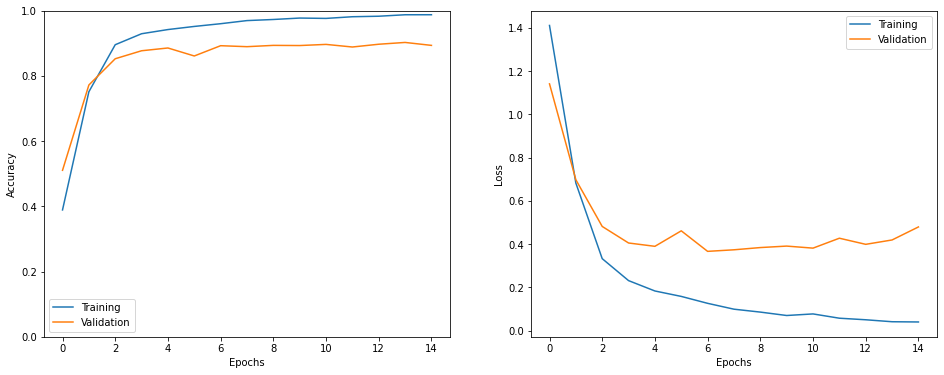

In [25]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [26]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [27]:
eval = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 21ms/step - loss: 0.5083 - accuracy: 0.8745


In [32]:
for a in range(0,5):
  i = random.randint(0, len(test_labels) - 1)

  print('Tweet:', test_tweets[i])
  print('Actual Emotion:', index_to_classes[test_labels[i]])

  p = np.argmax(model.predict(np.expand_dims(test_sequences[i], axis=0))[0])

  print('Predicted Emotion:', index_to_classes.get(p), '\n')

Tweet: im even feeling liked by the girls who hate pretty much everyone
Actual Emotion: love
Predicted Emotion: love 

Tweet: i cant walk into a shop anywhere where i do not feel uncomfortable
Actual Emotion: fear
Predicted Emotion: fear 

Tweet: i am reminded of pavement yurusei yatsura and coheed and cambria without feeling offended that they have ripped them off
Actual Emotion: anger
Predicted Emotion: anger 

Tweet: i want to feel assured that my life will be good and i know it will be when i trust the lord
Actual Emotion: joy
Predicted Emotion: joy 

Tweet: i was stupid and said yes which made me feel idiotic because i didnt stick to my guns and do what i had set out to do
Actual Emotion: sadness
Predicted Emotion: sadness 



In [30]:

preds = np.argmax(model.predict(test_sequences),axis=1)

preds.shape, test_labels.shape

((2000,), (2000,))

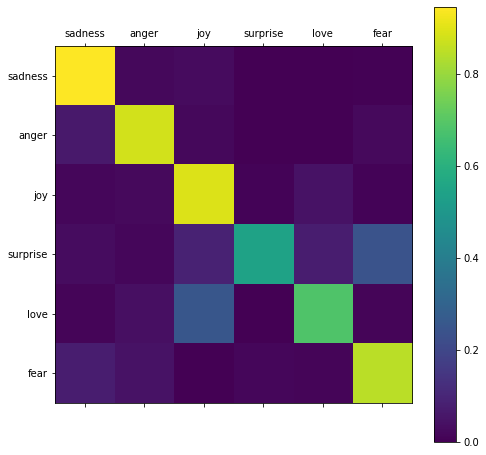

In [33]:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    
show_confusion_matrix(test_labels, preds, list(classes))